In [21]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
"""
Step 1
Prepare minutes price data
"""
input_path = 'data/三家银行A H分钟收盘价.xlsx'
df_input = pd.read_excel(input_path,converters = {'600036.SH': str, '3968.HK': str})

In [22]:
df_AH= pd.merge(df_input[['600036.SH', '招商银行','工商银行','农业银行']].drop([0,1]).dropna(), \
    df_input[['3968.HK', '招商银行.1','招商银行.1','工商银行.1','农业银行.1']].drop([0,1]).dropna(), \
        how='inner',left_on='600036.SH', right_on='3968.HK').drop('3968.HK',axis=1).rename(columns= {'600036.SH':'date'})
df_date = df_AH['date'].str.split(' ',expand=True).rename(columns={0:'date', 1:'time'})
df_AH['date'] = df_date['date'].str.replace('-','')
df_AH['time'] = df_date['time']

In [57]:
df_AH

,date,招商银行,工商银行,农业银行,招商银行.1,招商银行.1,工商银行.1,农业银行.1,time
0,20210104,41.640953,4.702477,2.948137,47.75,47.75,4.93,2.84,09:30
1,20210104,41.28013,4.702477,2.938718,47.7,47.7,4.89,2.82,09:31:00
2,20210104,41.289882,4.711957,2.938718,47.3,47.3,4.88,2.82,09:32:00
3,20210104,41.104594,4.702477,2.948137,47.3,47.3,4.89,2.82,09:33:00
4,20210104,41.124098,4.702477,2.948137,47.1,47.1,4.89,2.82,09:34:00
...,...,...,...,...,...,...,...,...,...
64716,20220225,49.98,4.68,2.97,65.55,65.55,4.67,2.95,11:12:00
64717,20220225,49.95,4.68,2.97,65.55,65.55,4.67,2.95,11:13:00
64718,20220225,49.88,4.69,2.97,65.45,65.45,4.65,2.95,11:14:00
64719,20220225,49.91,4.68,2.97,65.55,65.55,4.66,2.95,11:15:00


In [60]:
pro = ts.pro_api('00d803b166f55fc30c178d74c158985136010d6bd19271b182059eef')
start_date = '2021-01-04'
end_date = '2022-02-25'
df_CNY = pro.fx_daily(ts_code='USDCNH.FXCM', start_date=start_date, end_date=end_date).iloc[::-1].reset_index(drop=True)
df_HKD = pro.fx_daily(ts_code='USDHKD.FXCM', start_date=start_date, end_date=end_date).iloc[::-1].reset_index(drop=True)
feature_list_ex = ['trade_date', 'ask_close']

In [61]:
df_CNY[['trade_date','ask_close']]

,trade_date,ask_close
0,20210103,6.49920
1,20210104,6.45607
2,20210105,6.43781
3,20210106,6.45133
4,20210107,6.47202
...,...,...
304,20211227,6.37607
305,20211228,6.37552
306,20211229,6.37296
307,20211230,6.37668


In [ ]:
class stock:
    def __init__(self, name, df_AH):

        

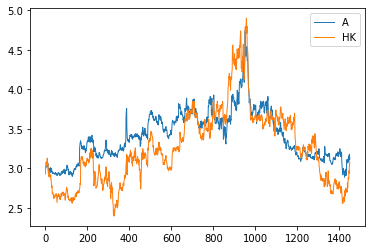

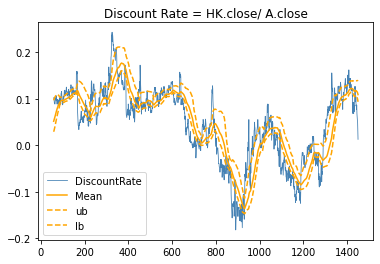

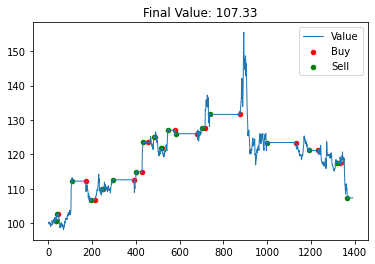

In [79]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
"""
Step 1
Read minutes price data
"""
input_path = 'data/三家银行A H分钟收盘价.xlsx'
df_input = pd.read_excel(input_path)

# Reserch time period start at 2016
start_date = '20160101'
end_date = '20220224'
# 农业银行
stock_code_H = ['01288.HK']
stock_code_A = ['601288.SH']

# download data from Tushare.pro
df_H = pro.hk_daily(ts_code=stock_code_H[0], start_date=start_date, end_date=end_date)
df_A = pro.daily(ts_code=stock_code_A[0], start_date=start_date, end_date=end_date)

"""
Step 2
Calculate discount rate
"""
# Features 
feature_list = ['trade_date','open','close']

# Innner connect two DataFrame, x for A and y for HK
df_AH = pd.merge(df_A, df_H, how='inner')

# calculate discount rate: DR
df_AH = pd.merge(df_A[feature_list], df_H[feature_list], how='inner',left_on='trade_date', right_on='trade_date')
plt.plot(df_AH.dropna()['close_x'],linewidth=1,label='A')
plt.plot(df_AH.dropna()['close_y'],linewidth=1,label='HK')
plt.legend()
plt.savefig('data/股价对比时序图.png',dpi=600, bbox_inches='tight')
plt.show()

# df_AH['DR'] = (df_AH['close_y'] - df_AH['close_x'])/df_AH['close_x']
df_AH['DR'] =1 - (df_AH['close_y'])/df_AH['close_x']


"""
Step 3
Analyze discount rate, including mean, std, variance
"""
rolling_window_size = 60
df_AH['DR_mean'] = df_AH['DR'].rolling(rolling_window_size).mean()
df_AH['DR_std'] = df_AH['DR'].rolling(rolling_window_size).std()
df_AH['DR_ub'] = df_AH['DR_mean']+df_AH['DR_std'] * 1
df_AH['DR_lb'] = df_AH['DR_mean']-df_AH['DR_std'] * 0.5
# plt.plot(df_AH[['DR','DR_mean']], color=['blue' ,'orange'], label=['DiscountRate' ,'Mean'])
plt.plot(df_AH.dropna()['DR'], color='steelblue', label='DiscountRate',linewidth=0.8)
plt.plot(df_AH.dropna()['DR_mean'], color='orange', label='Mean')
plt.plot(df_AH.dropna()['DR_ub'], color='orange',linestyle='--', label='ub')
plt.plot(df_AH.dropna()['DR_lb'], color='orange',linestyle='--', label='lb')
plt.legend()
plt.title('Discount Rate = HK.close/ A.close')
plt.savefig('data/折价率时序图.png',dpi=600, bbox_inches='tight')
plt.show()

"""
Step 4
Design trading rules
"""
def trading_rule(df):
    # extract data
    df = df.dropna(how='any')
    close = df['close_y'].values
    open = df['close_x'].values
    ub = df['DR_ub'].values
    lb = df['DR_lb'].values
    DR = df['DR'].values
    n = len(df)
    # initialize state
    value = np.zeros(n)
    buyPoint = np.zeros(n)
    sellPoint = np.zeros(n)
    psntValue = 100
    psntVolm = psntValue/open[0]
    isAllIn = True
    isSell = False
    isBuy = False
    for t in range(n):
        # cal present value
        if isAllIn:
            psntValue = psntVolm * open[t]
        value[t] = psntValue
        # no operation
        if not (isBuy or isSell):
            if DR[t] < lb[t] and isAllIn:
                isSell = True
                # all in
            elif DR[t] > ub[t] and not isAllIn:
                # all out
                isBuy = True
        # operation
        elif isBuy:
            buyPoint[t] = 1
            isBuy = False
            psntVolm = psntValue/open[t]
            isAllIn = True
        else:# sell
            sellPoint[t] = 1
            isSell = False
            isAllIn = False
    return value, psntValue, buyPoint, sellPoint
"""
Step 5
Evaluatioin
"""
value, psntValue, buyPoint, sellPoint = trading_rule(df_AH)

plt.plot(value, label='Value',linewidth=1)
plt.scatter(np.arange(len(value))[buyPoint == 1],value[buyPoint == 1],color='red',label='Buy',s=20)
plt.scatter(np.arange(len(value))[sellPoint == 1],value[sellPoint == 1],color='green',label='Sell',s=20)
plt.legend()
plt.title('Final Value: {:.2f}'.format(psntValue))
plt.savefig('data/资产价值时序图.png',dpi=600, bbox_inches='tight')
plt.show()



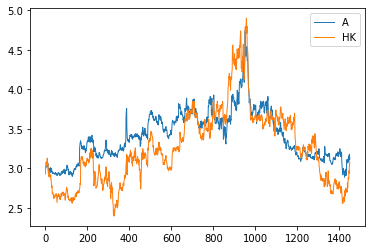

In [11]:
# df_ex = pro.fx_obasic(exchange='FXCM', classify='FX')
# df_ex.to_excel('data/汇率列表.xlsx')
# df_CNY = pro.fx_daily(ts_code='USDCNH.FXCM', start_date=start_date, end_date=end_date)
# df_HKD = pro.fx_daily(ts_code='USDHKD.FXCM', start_date=start_date, end_date=end_date)
# feature_list_ex = ['trade_date', 'ask_close']